# Imports

In [1]:
import os
import numpy
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# File Processing

In [2]:
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        print(f"Processing file: {filepath}")


Processing file: ./dataset\fhvhv_tripdata_2022-01.parquet
Processing file: ./dataset\fhvhv_tripdata_2022-02.parquet


# Loading Data & Data Verification

In [3]:
path_files = []

for year in range(2022, 2025):
    year_files = [files for files in os.listdir('./dataset') if f'_{year}-' in files]
    year_files.sort() 
    
    for file in year_files:
        path_files.append(pandas.read_parquet('./dataset/' + file))
        
print(f"Loaded {len(path_files)} files.")

Loaded 2 files.


In [4]:
df = pandas.concat(path_files, ignore_index=True)
print(f"Total rows: {len(df)}")

Total rows: 30770874


In [5]:
df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [6]:
df['base_passenger_fare'].describe()

count    3.077087e+07
mean     2.041490e+01
std      1.598893e+01
min     -5.201100e+02
25%      1.029000e+01
50%      1.609000e+01
75%      2.502000e+01
max      4.995960e+03
Name: base_passenger_fare, dtype: float64

# Data Cleaning

In [7]:
df = df[(df['base_passenger_fare'] >= 0) & (df['base_passenger_fare'] < 100)]
print(f"Rows after filtering by fare: {len(df)}")

Rows after filtering by fare: 30589303


In [8]:
df = df[(df['trip_miles'] >= 0) & (df['trip_miles'] < 100)]
print(f"Rows after filtering by miles: {len(df)}")

Rows after filtering by miles: 30589279


In [9]:
df = df[(df['trip_time'] >= 0) & (df['trip_time'] < 3000)]
print(f"Rows after filtering by time: {len(df)}")

Rows after filtering by time: 30007224


In [10]:
df = df[['hvfhs_license_num', 'request_datetime','trip_miles','trip_time', 'base_passenger_fare', 'tips', 'bcf', 'driver_pay', 'tolls', 'airport_fee', 'sales_tax', 'congestion_surcharge']]
df.describe()

,request_datetime,trip_miles,trip_time,base_passenger_fare,tips,bcf,driver_pay,tolls,airport_fee,sales_tax,congestion_surcharge
count,30007224,3.000722e+07,3.000722e+07,3.000722e+07,3.000722e+07,3.000722e+07,3.000722e+07,3.000722e+07,3.000722e+07,3.000722e+07,3.000722e+07
mean,2022-02-01 03:46:24.927536,4.291349e+00,9.991494e+02,1.914637e+01,7.895686e-01,6.018393e-01,1.495303e+01,8.048666e-01,1.352081e-01,1.685616e+00,1.115937e+00
min,2021-12-31 22:55:05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.865000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022-01-17 16:03:32,1.520000e+00,5.570000e+02,1.017000e+01,0.000000e+00,3.000000e-01,7.670000e+00,0.000000e+00,0.000000e+00,8.700000e-01,0.000000e+00
50%,2022-02-02 07:16:47,2.760000e+00,8.640000e+02,1.584000e+01,0.000000e+00,4.800000e-01,1.208000e+01,0.000000e+00,0.000000e+00,1.370000e+00,0.000000e+00
75%,2022-02-15 16:33:50,5.460000e+00,1.313000e+03,2.415000e+01,0.000000e+00,7.500000e-01,1.924000e+01,0.000000e+00,0.000000e+00,2.130000e+00,2.750000e+00
max,2022-03-01 00:10:00,5.012500e+01,2.999000e+03,9.999000e+01,2.000000e+02,7.740000e+00,3.032100e+02,8.000000e+01,5.000000e+00,2.292000e+01,1.100000e+01
std,NaN,4.222243e+00,5.801446e+02,1.203645e+01,2.208923e+00,4.184457e-01,9.684675e+00,3.122377e+00,5.686063e-01,1.127249e+00,1.361335e+00


# Feature Engineering

In [11]:
df['request_hour'] = df['request_datetime'].dt.hour
df['request_day_of_week'] = df['request_datetime'].dt.dayofweek

In [12]:
encoder = LabelEncoder()
df['hvfhs_license_num_encoded'] = encoder.fit_transform(df['hvfhs_license_num'])
df = df.drop(columns=['hvfhs_license_num'])

# Feature Correlation Heatmap

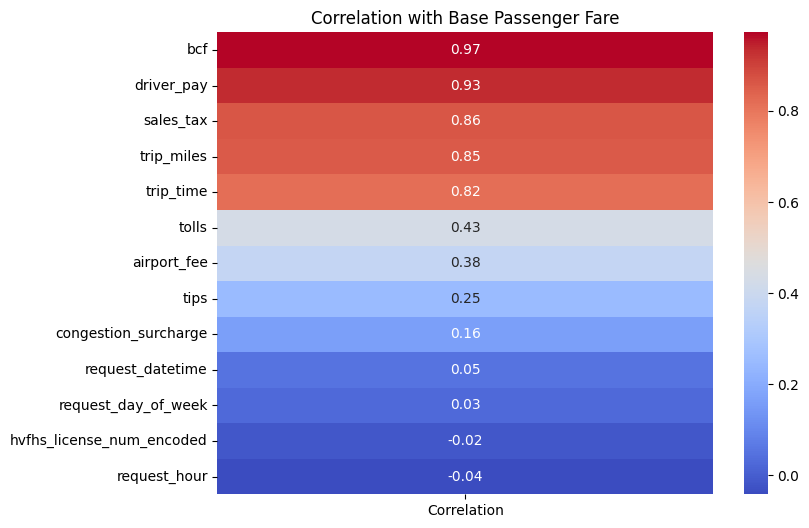

In [13]:
target_correlation = df.corr()['base_passenger_fare'].drop('base_passenger_fare') 

corr_df = target_correlation.to_frame(name='Correlation').sort_values(by='Correlation', ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", cbar=True, fmt=".2f")
plt.title("Correlation with Base Passenger Fare")
plt.show()

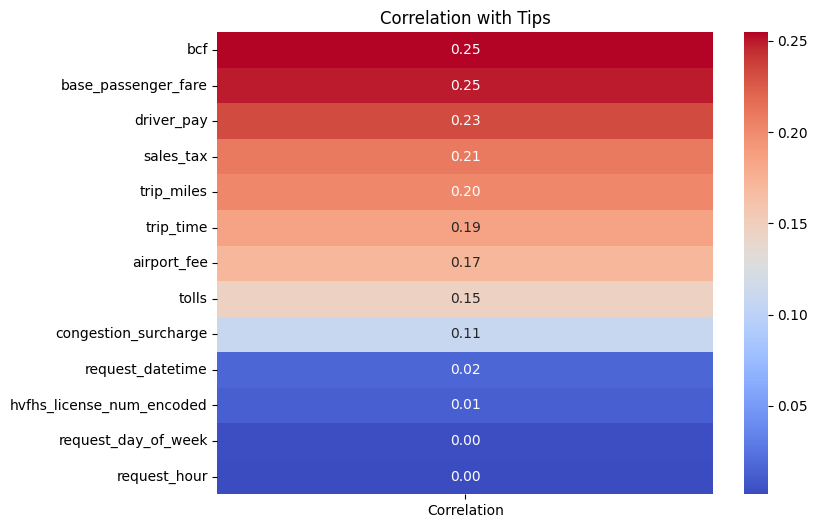

In [14]:
target_correlation = df.corr()['tips'].drop('tips') 

corr_df = target_correlation.to_frame(name='Correlation').sort_values(by='Correlation', ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", cbar=True, fmt=".2f")
plt.title("Correlation with Tips")
plt.show()

# Spliting Data (Train, Validation, Test)

In [15]:
# Train: Days 1–20
train_data = df[df['request_datetime'].dt.day <= 20]

# Validation: Days 21–25
validation_data = df[(df['request_datetime'].dt.day >= 21) & (df['request_datetime'].dt.day <= 25)]

# Test: Days 26–end of the month
test_data = df[df['request_datetime'].dt.day >= 26]

In [16]:
train_data = train_data.drop(columns=['request_datetime'])
validation_data = validation_data.drop(columns=['request_datetime'])
test_data = test_data.drop(columns=['request_datetime'])

# Data Normalization

In [17]:
columns_to_scale = ['trip_miles', 'trip_time', 'base_passenger_fare', 'tips']

scaler = StandardScaler()

# Training data
train_data_scaled = train_data.copy()
train_data_scaled[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])

# Validation data
validation_data_scaled = validation_data.copy()
validation_data_scaled[columns_to_scale] = scaler.transform(validation_data[columns_to_scale])

# Test data
test_data_scaled = test_data.copy()
test_data_scaled[columns_to_scale] = scaler.transform(test_data[columns_to_scale])

In [18]:
print("Train Data Sample:")
train_data[:10]

Train Data Sample:


,trip_miles,trip_time,base_passenger_fare,tips,bcf,driver_pay,tolls,airport_fee,sales_tax,congestion_surcharge,request_hour,request_day_of_week,hvfhs_license_num_encoded
0,1.18,664,24.90,0.0,0.75,23.03,0.0,0.0,2.21,2.75,0,5,0
1,0.82,460,11.97,0.0,0.36,12.32,0.0,0.0,1.06,2.75,0,5,0
2,1.18,595,29.82,0.0,0.89,23.30,0.0,0.0,2.65,2.75,0,5,0
3,1.65,303,7.91,0.0,0.24,6.30,0.0,0.0,0.70,2.75,0,5,0
4,1.65,461,9.44,0.0,0.28,7.44,0.0,0.0,0.84,2.75,0,5,0
5,4.51,762,17.67,0.0,0.53,12.25,0.0,0.0,1.57,2.75,0,5,0
6,3.68,931,16.68,0.0,0.50,12.75,0.0,0.0,1.48,2.75,0,5,0
7,2.77,843,14.41,4.0,0.43,11.47,0.0,0.0,1.28,0.00,0,5,0
8,2.04,710,10.64,0.0,0.32,9.55,0.0,0.0,0.94,2.75,0,5,0
10,11.29,1387,34.90,0.0,1.05,25.17,0.0,0.0,3.10,2.75,0,5,0


In [19]:
print("Validation Data Sample:")
validation_data[:10]

Validation Data Sample:


,trip_miles,trip_time,base_passenger_fare,tips,bcf,driver_pay,tolls,airport_fee,sales_tax,congestion_surcharge,request_hour,request_day_of_week,hvfhs_license_num_encoded
9149683,4.460,760,17.93,0.0,0.54,11.55,0.0,0.0,1.59,0.00,0,4,0
9149807,2.380,611,12.08,0.0,0.36,7.75,0.0,0.0,1.07,0.00,0,4,0
9150931,14.470,2193,43.78,0.0,1.31,35.94,0.0,0.0,3.89,2.75,0,4,0
9154127,1.380,583,8.95,0.0,0.32,7.38,0.0,0.0,0.93,0.00,0,4,0
9154380,9.470,995,27.70,0.0,0.83,20.59,0.0,0.0,2.46,2.75,0,4,0
9157991,10.270,1532,28.35,0.0,0.85,25.69,0.0,0.0,2.52,2.75,0,4,0
9159006,4.740,1239,21.75,0.0,0.65,17.40,0.0,0.0,1.93,0.00,0,4,0
9161684,0.890,389,8.41,0.0,0.25,5.89,0.0,0.0,0.75,0.00,0,4,0
9164521,19.640,1777,50.04,0.0,1.50,40.00,0.0,0.0,4.44,0.00,0,4,0
9165178,5.846,1242,23.88,0.0,0.72,16.89,0.0,0.0,2.12,0.00,0,4,1


In [20]:
df[['trip_miles', 'trip_time', 'base_passenger_fare', 'tips']] = scaler.fit_transform(
    df[['trip_miles', 'trip_time', 'base_passenger_fare', 'tips']]
)


In [21]:
df['hour'] = pandas.to_datetime(df['request_datetime']).dt.hour
df['day_of_week'] = pandas.to_datetime(df['request_datetime']).dt.dayofweek

# Base Passenger Fare Model

## Prepare Data

In [22]:
target_column = 'base_passenger_fare'

# Extract features and targets
X_train = train_data_scaled.drop(columns=[target_column])
y_train = train_data_scaled[target_column]

X_val = validation_data_scaled.drop(columns=[target_column])
y_val = validation_data_scaled[target_column]

X_test = test_data_scaled.drop(columns=[target_column])
y_test = test_data_scaled[target_column]


## Neural Network 

In [23]:
# Define the model
model = Sequential([
    # Explicit Input Layer
    Input(shape=(X_train.shape[1],)),

    # First Hidden Layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Second Hidden Layer
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Third Hidden Layer
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output Layer
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


## Train and Evaluate Model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
629409/629409 ━━━━━━━━━━━━━━━━━━━━ 3417s 5ms/step - loss: 0.0845 - mae: 0.2035 - val_loss: 0.9510 - val_mae: 0.0925
Epoch 2/20
629409/629409 ━━━━━━━━━━━━━━━━━━━━ 2300s 4ms/step - loss: 0.0699 - mae: 0.1917 - val_loss: 0.0218 - val_mae: 0.0854
Epoch 3/20
629409/629409 ━━━━━━━━━━━━━━━━━━━━ 2070s 3ms/step - loss: 0.0691 - mae: 0.1909 - val_loss: 0.0659 - val_mae: 0.0898
Epoch 4/20
629409/629409 ━━━━━━━━━━━━━━━━━━━━ 1567s 2ms/step - loss: 0.0692 - mae: 0.1906 - val_loss: 0.3866 - val_mae: 0.0945
Epoch 5/20
629409/629409 ━━━━━━━━━━━━━━━━━━━━ 1577s 3ms/step - loss: 0.0686 - mae: 0.1903 - val_loss: 0.1327 - val_mae: 0.0975
Epoch 6/20
629409/629409 ━━━━━━━━━━━━━━━━━━━━ 2450s 4ms/step - loss: 0.0686 - mae: 0.1903 - val_loss: 0.1126 - val_mae: 0.0995
Epoch 7/20


In [ ]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = numpy.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)

## Plot Training History

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

## Compare Fare Predictions for Uber/Lyft

In [ ]:
license_plates = {'HV0003': 'Uber', 'HV0005': 'Lyft'}

for plate, company in license_plates.items():
    group_data = test_data_scaled[test_data_scaled['hvfhs_license_num_encoded'] == encoder.transform([plate])[0]]
    X_group = group_data.drop(columns=[target_column])
    y_group_true = group_data[target_column]
    
    y_group_pred = model.predict(X_group)
    
    # Compute metrics for this group
    group_rmse = numpy.sqrt(mean_squared_error(y_group_true, y_group_pred))
    group_mae = mean_absolute_error(y_group_true, y_group_pred)
    
    print(f"{company} ({plate}) - RMSE: {group_rmse:.2f}, MAE: {group_mae:.2f}")
    
    # Plot true vs. predicted fares
    plt.figure(figsize=(10, 5))
    plt.scatter(y_group_true, y_group_pred, alpha=0.5, label=f"{company} Predictions")
    plt.plot([y_group_true.min(), y_group_true.max()], [y_group_true.min(), y_group_true.max()], 'r--', label='Ideal Prediction')
    plt.title(f"True vs. Predicted Base Passenger Fare for {company}")
    plt.xlabel('True Fare')
    plt.ylabel('Predicted Fare')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

## Evaluate Accuracy by Hour

In [ ]:
test_data_scaled['request_hour'] = test_data['request_hour']

# Group by hour and compute average RMSE
hourly_rmse = test_data_scaled.groupby('request_hour').apply(
    lambda group: numpy.sqrt(mean_squared_error(group[target_column], model.predict(group.drop(columns=[target_column]))))
)

# Plot hourly RMSE
plt.figure(figsize=(12, 6))
hourly_rmse.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Hourly RMSE for Fare Predictions')
plt.xlabel('Hour of the Day')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()

# Tips Model

## Prepare Data

In [ ]:
target_column = 'tips'

# Extract features and targets
X_train = train_data_scaled.drop(columns=[target_column])
y_train = train_data_scaled[target_column]

X_val = validation_data_scaled.drop(columns=[target_column])
y_val = validation_data_scaled[target_column]

X_test = test_data_scaled.drop(columns=[target_column])
y_test = test_data_scaled[target_column]


## Neural Network Model

In [ ]:
# Define the model
model = Sequential([
    # Explicit Input Layer
    Input(shape=(X_train.shape[1],)),

    # First Hidden Layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Second Hidden Layer
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Third Hidden Layer
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output Layer
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


## Train and Evaluate Model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = numpy.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)

## Plot Training History

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()